In [26]:
!pip install kaggle --quiet

In [27]:
import os
from google.colab import files

In [28]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kumarsachin2004","key":"c0ec7fe5666ae06cf515e982cc29a4d5"}'}

In [29]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [30]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
!unzip -qo chest-xray-pneumonia.zip -x "__MACOSX/*"


caution: excluded filename not matched:  __MACOSX/*


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [34]:
# ========================================
# STEP 4: Data Preprocessing
# ========================================
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [35]:
# ========================================
# STEP 5: Build Transfer Learning Model (ResNet50)
# ========================================
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Clear any previous models (important if you re-run cells)
tf.keras.backend.clear_session()

# Load pre-trained ResNet50
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze base model layers
# Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Add custom classifier
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 14,974,977 (57.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)


In [37]:
# ========================================
# STEP 6: Train Model
# ========================================
# IMPORTANT: change target_size to (224,224) in ImageDataGenerator earlier

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint]
)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.7501 - loss: 0.4710

163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 657ms/step - accuracy: 0.7505 - loss: 0.4704 - val_accuracy: 0.6875 - val_loss: 0.6783 - learning_rate: 1.0000e-05
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 632ms/step - accuracy: 0.8713 - loss: 0.2896 - val_accuracy: 0.6875 - val_loss: 0.8914 - learning_rate: 1.0000e-05
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.8774 - loss: 0.2833

163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 655ms/step - accuracy: 0.8774 - loss: 0.2833 - val_accuracy: 0.8125 - val_loss: 0.8193 - learning_rate: 1.0000e-05
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8753 - loss: 0.2680
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 628ms/step - accuracy: 0.8753 - loss: 0.2679 - val_accuracy: 0.6250 - val_loss: 1.0495 - learning_rate: 1.0000e-05
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 626ms/step - accuracy: 0.8972 - loss: 0.2362 - val_accuracy: 0.6875 - val_loss: 0.9926 - learning_rate: 2.0000e-06
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 622ms/step - accuracy: 0.9061 - loss: 0.2261 - val_accuracy: 0.7500 - val_loss: 0.7719 - learning_rate: 2.0000e-06


In [38]:
# ========================================
# STEP 7: Evaluate Model
# ========================================
from tensorflow.keras.models import load_model
best_model = load_model("best_model.h5")

test_loss, test_acc = best_model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")



20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 366ms/step - accuracy: 0.8661 - loss: 0.3282
✅ Test Accuracy: 86.70%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


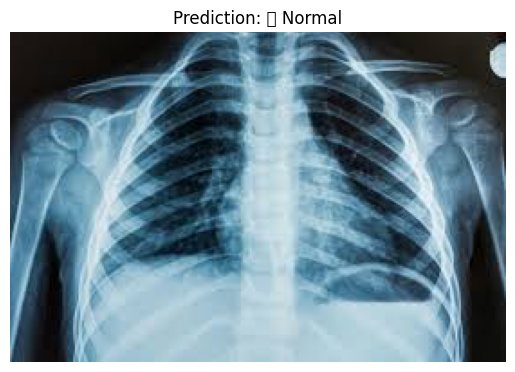

Prediction: ✅ Normal


In [43]:
# ========================================
# STEP 9: Prediction on New Image with Display
# ========================================
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
img_path = "x-rayim.jpeg"
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (224,224)) / 255.0
img_expanded = np.expand_dims(img_resized, axis=0)

# Prediction
prediction = model.predict(img_expanded)
result = "🫁 Pneumonia" if prediction[0][0] > 0.5 else "✅ Normal"

# Show the image with prediction label
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {result}")
plt.axis("off")
plt.show()

print("Prediction:", result)
